# 📊 Model Evaluation Analysis - CNN/DailyMail Dataset

**Smart Summarizer - Comprehensive Model Evaluation**

This notebook evaluates TextRank, BART, and PEGASUS models using ROUGE metrics on the official CNN/DailyMail dataset.

**Dataset**: CNN/DailyMail (abisee/cnn_dailymail v3.0.0)  
**Author**: Abdul Razzaq Ansari  
**Student ID**: 23049149  
**Module**: CU6051NI Artificial Intelligence

In [1]:
# Cell 1: Setup and Imports
import sys
import os
sys.path.append('..')

# Ensure required directories exist
os.makedirs('../data/samples', exist_ok=True)
os.makedirs('../data/results', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Import models and utilities
from models.textrank import TextRankSummarizer
from models.bart import BARTSummarizer
from models.pegasus import PEGASUSSummarizer
from utils.evaluator import SummarizerEvaluator
from utils.data_loader import DataLoader

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import warnings
warnings.filterwarnings('ignore')

# Import datasets library for CNN/DailyMail
try:
    from datasets import load_dataset
    print("✅ HuggingFace datasets library available")
except ImportError:
    print("⚠️ datasets library not found. Install with: pip install datasets")

plt.style.use('seaborn-v0_8')
print("✅ All imports successful")
print("✅ Directories created")

✅ HuggingFace datasets library available
✅ All imports successful
✅ Directories created


In [2]:
# Cell 2: Load CNN/DailyMail Test Dataset
print("📊 Loading CNN/DailyMail test dataset...")
loader = DataLoader()

def load_cnn_dailymail_test_data(num_samples=50):
    """Load test data from official CNN/DailyMail dataset"""
    try:
        # Try to load existing cached samples first
        cached_file = '../data/samples/cnn_dailymail_test.json'
        test_data = loader.load_samples(cached_file)
        
        if len(test_data) >= num_samples:
            print(f"✅ Loaded {len(test_data)} cached CNN/DailyMail samples")
            return test_data[:num_samples]
        else:
            print("📥 Loading fresh data from HuggingFace...")
            
    except:
        print("📥 No cached data found, loading from HuggingFace...")
    
    # Load from HuggingFace CNN/DailyMail dataset
    try:
        print("🔄 Downloading CNN/DailyMail dataset (this may take a moment)...")
        dataset = load_dataset('abisee/cnn_dailymail', '3.0.0', split='test')
        
        # Select samples
        selected_data = dataset.select(range(min(num_samples, len(dataset))))
        
        # Convert to our format
        test_data = []
        for i, item in enumerate(selected_data):
            test_data.append({
                'article': item['article'],
                'reference_summary': item['highlights'],
                'id': item.get('id', f'cnn_dm_{i}')
            })
        
        print(f"✅ Successfully loaded {len(test_data)} samples from CNN/DailyMail")
        
        # Cache for future use
        loader.save_samples(test_data, cached_file)
        print(f"✅ Cached samples for future use")
        
        return test_data
        
    except Exception as e:
        print(f"❌ Failed to load CNN/DailyMail: {e}")
        print("⚠️ Falling back to built-in sample data")
        return loader._load_sample_data()

# Load test data
test_data = load_cnn_dailymail_test_data(num_samples=20)  # Start with 20 samples

# Extract texts and references
texts = [item['article'] for item in test_data]
references = [item['reference_summary'] for item in test_data]

print(f"\n📈 Dataset Statistics:")
print(f"  - Number of samples: {len(texts)}")
if len(texts) > 0:
    article_lengths = [len(t.split()) for t in texts]
    summary_lengths = [len(r.split()) for r in references]
    print(f"  - Avg article length: {np.mean(article_lengths):.0f} words")
    print(f"  - Avg reference length: {np.mean(summary_lengths):.0f} words")
    print(f"  - Compression ratio: {np.mean(summary_lengths)/np.mean(article_lengths):.2%}")
    print(f"  - Article length range: {min(article_lengths)} - {max(article_lengths)} words")
else:
    print("  - ❌ No data loaded!")

INFO:utils.data_loader:DataLoader initialized with cache dir: ./data/cache


📊 Loading CNN/DailyMail test dataset...
📥 Loading fresh data from HuggingFace...
🔄 Downloading CNN/DailyMail dataset (this may take a moment)...


INFO:utils.data_loader:Saved 20 samples to ../data/samples/cnn_dailymail_test.json


✅ Successfully loaded 20 samples from CNN/DailyMail
✅ Cached samples for future use

📈 Dataset Statistics:
  - Number of samples: 20
  - Avg article length: 530 words
  - Avg reference length: 37 words
  - Compression ratio: 6.92%
  - Article length range: 111 - 1133 words


In [3]:
# Cell 3: Preview Sample Data
if len(test_data) > 0:
    print("📋 Sample Article and Reference Summary:")
    print("=" * 80)
    
    sample = test_data[0]
    article = sample['article']
    reference = sample['reference_summary']
    
    print(f"\n📰 ARTICLE (ID: {sample.get('id', 'N/A')})")
    print("-" * 40)
    print(f"{article[:500]}..." if len(article) > 500 else article)
    print(f"\n[Full length: {len(article.split())} words]")
    
    print(f"\n📝 REFERENCE SUMMARY")
    print("-" * 40)
    print(reference)
    print(f"\n[Length: {len(reference.split())} words]")
    
    print(f"\n📊 Compression: {len(reference.split())/len(article.split()):.2%}")
    print("=" * 80)
else:
    print("❌ No sample data available for preview")

📋 Sample Article and Reference Summary:

📰 ARTICLE (ID: f001ec5c4704938247d27a44948eebb37ae98d01)
----------------------------------------
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, includin...

[Full length: 567 words]

📝 REFERENCE SUMMARY
----------------------------------------
Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .

[Length: 36 words]

📊 Compression:

In [4]:
# Cell 4: Initialize Models
print("🤖 Initializing models...")

models = {}

try:
    models['TextRank'] = TextRankSummarizer()
    print("✅ TextRank initialized")
except Exception as e:
    print(f"❌ TextRank failed: {e}")

try:
    models['BART'] = BARTSummarizer(device='cpu')
    print("✅ BART initialized")
except Exception as e:
    print(f"❌ BART failed: {e}")

try:
    models['PEGASUS'] = PEGASUSSummarizer(device='cpu')
    print("✅ PEGASUS initialized")
except Exception as e:
    print(f"❌ PEGASUS failed: {e}")

print(f"\n🎯 Successfully initialized {len(models)} models")
print(f"Models available: {list(models.keys())}")

if len(models) == 0:
    print("❌ No models available! Please check model installations.")
    raise RuntimeError("No models initialized")

INFO:models.base_summarizer:Initializing TextRank (Extractive) summarizer
INFO:models.textrank:TextRank summarizer initialized successfully
INFO:models.base_summarizer:Initializing BART (Abstractive) summarizer
INFO:models.bart:Loading BART model: facebook/bart-large-cnn
INFO:models.bart:Initial model loading may take 2-3 minutes...
INFO:models.bart:Using device: cpu


🤖 Initializing models...
✅ TextRank initialized


INFO:models.bart:BART model loaded successfully!
INFO:models.base_summarizer:Initializing PEGASUS (Abstractive) summarizer
INFO:models.pegasus:Loading PEGASUS model: google/pegasus-cnn_dailymail
INFO:models.pegasus:PEGASUS is a large model. Initial loading may take 3-5 minutes...
INFO:models.pegasus:Using device: cpu
INFO:models.pegasus:Loading tokenizer...


✅ BART initialized


INFO:models.pegasus:Loading model weights...
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:models.pegasus:PEGASUS model loaded successfully!
INFO:models.pegasus:Model size: 568.7M parameters


✅ PEGASUS initialized

🎯 Successfully initialized 3 models
Models available: ['TextRank', 'BART', 'PEGASUS']


In [5]:
# Cell 5: Generate Summaries with Progress Tracking
print("📝 Generating summaries for all models...")
print(f"Processing {len(texts)} CNN/DailyMail samples...")

all_summaries = {}
all_times = {}

for model_name, model in models.items():
    print(f"\n🔄 Processing with {model_name}...")
    summaries = []
    times = []
    
    for i, text in enumerate(texts, 1):
        print(f"  Processing {i}/{len(texts)}...", end='\r')
        
        try:
            if model_name == 'TextRank':
                result = model.summarize_with_metrics(text)
            else:
                # Use appropriate parameters for CNN/DailyMail
                result = model.summarize_with_metrics(
                    text, 
                    max_length=142,  # CNN/DailyMail average summary length
                    min_length=56    # Minimum reasonable length
                )
            
            summaries.append(result['summary'])
            times.append(result['metadata']['processing_time'])
            
        except Exception as e:
            print(f"\n  ❌ Error processing sample {i}: {e}")
            summaries.append("Error: Could not generate summary")
            times.append(0.0)
    
    all_summaries[model_name] = summaries
    all_times[model_name] = times
    
    # Calculate success rate
    successful = len([s for s in summaries if not s.startswith("Error:")])
    print(f"  ✅ Completed {model_name}: {successful}/{len(summaries)} successful summaries")

print("\n🎉 All summaries generated!")

# Show sample outputs
if len(texts) > 0:
    print("\n📋 Sample Summary Comparison (First Article):")
    print("=" * 80)
    print(f"Original (first 200 chars): {texts[0][:200]}...")
    print(f"Reference: {references[0]}")
    print("-" * 40)
    for model_name in models.keys():
        if len(all_summaries[model_name]) > 0:
            summary = all_summaries[model_name][0]
            if not summary.startswith("Error:"):
                print(f"{model_name}: {summary[:200]}..." if len(summary) > 200 else f"{model_name}: {summary}")
            else:
                print(f"{model_name}: {summary}")
    print("=" * 80)

📝 Generating summaries for all models...
Processing 20 CNN/DailyMail samples...

🔄 Processing with TextRank...
  ✅ Completed TextRank: 20/20 successful summaries

🔄 Processing with BART...
  ✅ Completed BART: 20/20 successful summaries

🔄 Processing with PEGASUS...
  ✅ Completed PEGASUS: 20/20 successful summaries

🎉 All summaries generated!

📋 Sample Summary Comparison (First Article):
Original (first 200 chars): (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territor...
Reference: Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .
----------------------------------------
TextRank: (CNN)The Palestinian Authority officially became the 123rd member of the Internati

In [6]:
# Cell 6: Evaluate Models with CNN/DailyMail Metrics
print("📊 Evaluating models on CNN/DailyMail dataset...")

evaluator = SummarizerEvaluator()
evaluation_results = {}

def safe_evaluate_batch(evaluator, summaries, references, model_name):
    """Safely evaluate batch with error handling"""
    if len(summaries) == 0 or len(references) == 0:
        return {
            'model_name': model_name,
            'num_samples': 0,
            'rouge_1_f1_mean': 0.0,
            'rouge_1_f1_std': 0.0,
            'rouge_2_f1_mean': 0.0,
            'rouge_2_f1_std': 0.0,
            'rouge_l_f1_mean': 0.0,
            'rouge_l_f1_std': 0.0,
            'compression_ratio_mean': 0.0,
            'compression_ratio_std': 0.0,
            'individual_scores': []
        }
    
    try:
        return evaluator.evaluate_batch(summaries, references, model_name)
    except Exception as e:
        print(f"❌ Evaluation failed for {model_name}: {e}")
        return safe_evaluate_batch(evaluator, [], [], model_name)  # Return empty result

for model_name in models.keys():
    print(f"\n🔍 Evaluating {model_name} on CNN/DailyMail...")
    
    # Get summaries and corresponding references
    model_summaries = all_summaries[model_name]
    model_references = references[:len(model_summaries)]
    
    # Filter out error summaries
    valid_summaries = []
    valid_references = []
    for i, summary in enumerate(model_summaries):
        if not summary.startswith("Error:") and i < len(model_references):
            valid_summaries.append(summary)
            valid_references.append(model_references[i])
    
    print(f"  Valid summaries: {len(valid_summaries)}/{len(model_summaries)}")
    
    # Evaluate
    results = safe_evaluate_batch(evaluator, valid_summaries, valid_references, model_name)
    
    # Add timing information
    valid_times = [t for t in all_times[model_name] if t > 0]
    results['avg_time'] = np.mean(valid_times) if valid_times else 0.0
    results['std_time'] = np.std(valid_times) if valid_times else 0.0
    results['total_time'] = sum(valid_times) if valid_times else 0.0
    
    evaluation_results[model_name] = results
    
    if results['num_samples'] > 0:
        print(f"  ✅ {model_name} evaluated:")
        print(f"     ROUGE-1: {results['rouge_1_f1_mean']:.4f} ± {results['rouge_1_f1_std']:.4f}")
        print(f"     ROUGE-2: {results['rouge_2_f1_mean']:.4f} ± {results['rouge_2_f1_std']:.4f}")
        print(f"     ROUGE-L: {results['rouge_l_f1_mean']:.4f} ± {results['rouge_l_f1_std']:.4f}")
        print(f"     Avg Time: {results['avg_time']:.3f}s per sample")
    else:
        print(f"  ❌ {model_name}: No valid results")

print("\n🎯 CNN/DailyMail evaluation complete!")

INFO:absl:Using default tokenizer.
INFO:utils.evaluator:Evaluator initialized with rouge_score library
INFO:utils.evaluator:Evaluating 20 summaries for TextRank


📊 Evaluating models on CNN/DailyMail dataset...

🔍 Evaluating TextRank on CNN/DailyMail...
  Valid summaries: 20/20


INFO:utils.evaluator:Evaluating 20 summaries for BART
INFO:utils.evaluator:Evaluating 20 summaries for PEGASUS


  ✅ TextRank evaluated:
     ROUGE-1: 0.2507 ± 0.1249
     ROUGE-2: 0.1035 ± 0.0727
     ROUGE-L: 0.1637 ± 0.0790
     Avg Time: 0.006s per sample

🔍 Evaluating BART on CNN/DailyMail...
  Valid summaries: 20/20
  ✅ BART evaluated:
     ROUGE-1: 0.3502 ± 0.0919
     ROUGE-2: 0.1479 ± 0.0839
     ROUGE-L: 0.2604 ± 0.1019
     Avg Time: 11.737s per sample

🔍 Evaluating PEGASUS on CNN/DailyMail...
  Valid summaries: 20/20
  ✅ PEGASUS evaluated:
     ROUGE-1: 0.3530 ± 0.1072
     ROUGE-2: 0.1532 ± 0.0876
     ROUGE-L: 0.2549 ± 0.0960
     Avg Time: 19.364s per sample

🎯 CNN/DailyMail evaluation complete!


In [7]:
# Cell 7: Display CNN/DailyMail Results
print("\n" + "="*80)
print("📊 CNN/DAILYMAIL EVALUATION RESULTS")
print("="*80)

results_table = []

for model_name, results in evaluation_results.items():
    if results['num_samples'] > 0:
        results_table.append({
            'Model': model_name,
            'Type': 'Extractive' if model_name == 'TextRank' else 'Abstractive',
            'ROUGE-1': f"{results['rouge_1_f1_mean']:.4f} ± {results['rouge_1_f1_std']:.4f}",
            'ROUGE-2': f"{results['rouge_2_f1_mean']:.4f} ± {results['rouge_2_f1_std']:.4f}",
            'ROUGE-L': f"{results['rouge_l_f1_mean']:.4f} ± {results['rouge_l_f1_std']:.4f}",
            'Avg Time (s)': f"{results['avg_time']:.3f} ± {results['std_time']:.3f}",
            'Total Time (s)': f"{results['total_time']:.1f}",
            'Samples': results['num_samples']
        })
    else:
        results_table.append({
            'Model': model_name,
            'Type': 'Extractive' if model_name == 'TextRank' else 'Abstractive',
            'ROUGE-1': 'N/A',
            'ROUGE-2': 'N/A',
            'ROUGE-L': 'N/A',
            'Avg Time (s)': 'N/A',
            'Total Time (s)': 'N/A',
            'Samples': 0
        })

results_df = pd.DataFrame(results_table)
print(results_df.to_string(index=False))

# Save results
try:
    results_df.to_csv('../results/cnn_dailymail_evaluation_results.csv', index=False)
    print("\n✅ Results saved to results/cnn_dailymail_evaluation_results.csv")
except Exception as e:
    print(f"\n⚠️ Could not save CSV: {e}")

# Calculate and display key insights
valid_results = {k: v for k, v in evaluation_results.items() if v['num_samples'] > 0}
if len(valid_results) > 0:
    print(f"\n🏆 CNN/DailyMail Performance Ranking:")
    
    # Rank by ROUGE-1
    rouge1_ranking = sorted(valid_results.items(), 
                           key=lambda x: x[1]['rouge_1_f1_mean'], reverse=True)
    
    for i, (model, results) in enumerate(rouge1_ranking, 1):
        print(f"  {i}. {model}: ROUGE-1 = {results['rouge_1_f1_mean']:.4f}")
    
    # Speed comparison
    speed_ranking = sorted(valid_results.items(), 
                          key=lambda x: x[1]['avg_time'])
    
    print(f"\n⚡ Speed Ranking (fastest first):")
    for i, (model, results) in enumerate(speed_ranking, 1):
        print(f"  {i}. {model}: {results['avg_time']:.3f}s per sample")


📊 CNN/DAILYMAIL EVALUATION RESULTS
   Model        Type         ROUGE-1         ROUGE-2         ROUGE-L    Avg Time (s) Total Time (s)  Samples
TextRank  Extractive 0.2507 ± 0.1249 0.1035 ± 0.0727 0.1637 ± 0.0790   0.006 ± 0.006            0.1       20
    BART Abstractive 0.3502 ± 0.0919 0.1479 ± 0.0839 0.2604 ± 0.1019  11.737 ± 2.686          234.7       20
 PEGASUS Abstractive 0.3530 ± 0.1072 0.1532 ± 0.0876 0.2549 ± 0.0960 19.364 ± 10.535          387.3       20

✅ Results saved to results/cnn_dailymail_evaluation_results.csv

🏆 CNN/DailyMail Performance Ranking:
  1. PEGASUS: ROUGE-1 = 0.3530
  2. BART: ROUGE-1 = 0.3502
  3. TextRank: ROUGE-1 = 0.2507

⚡ Speed Ranking (fastest first):
  1. TextRank: 0.006s per sample
  2. BART: 11.737s per sample
  3. PEGASUS: 19.364s per sample



📈 Creating CNN/DailyMail evaluation visualizations...
✅ Visualization saved to results/cnn_dailymail_evaluation_results.png


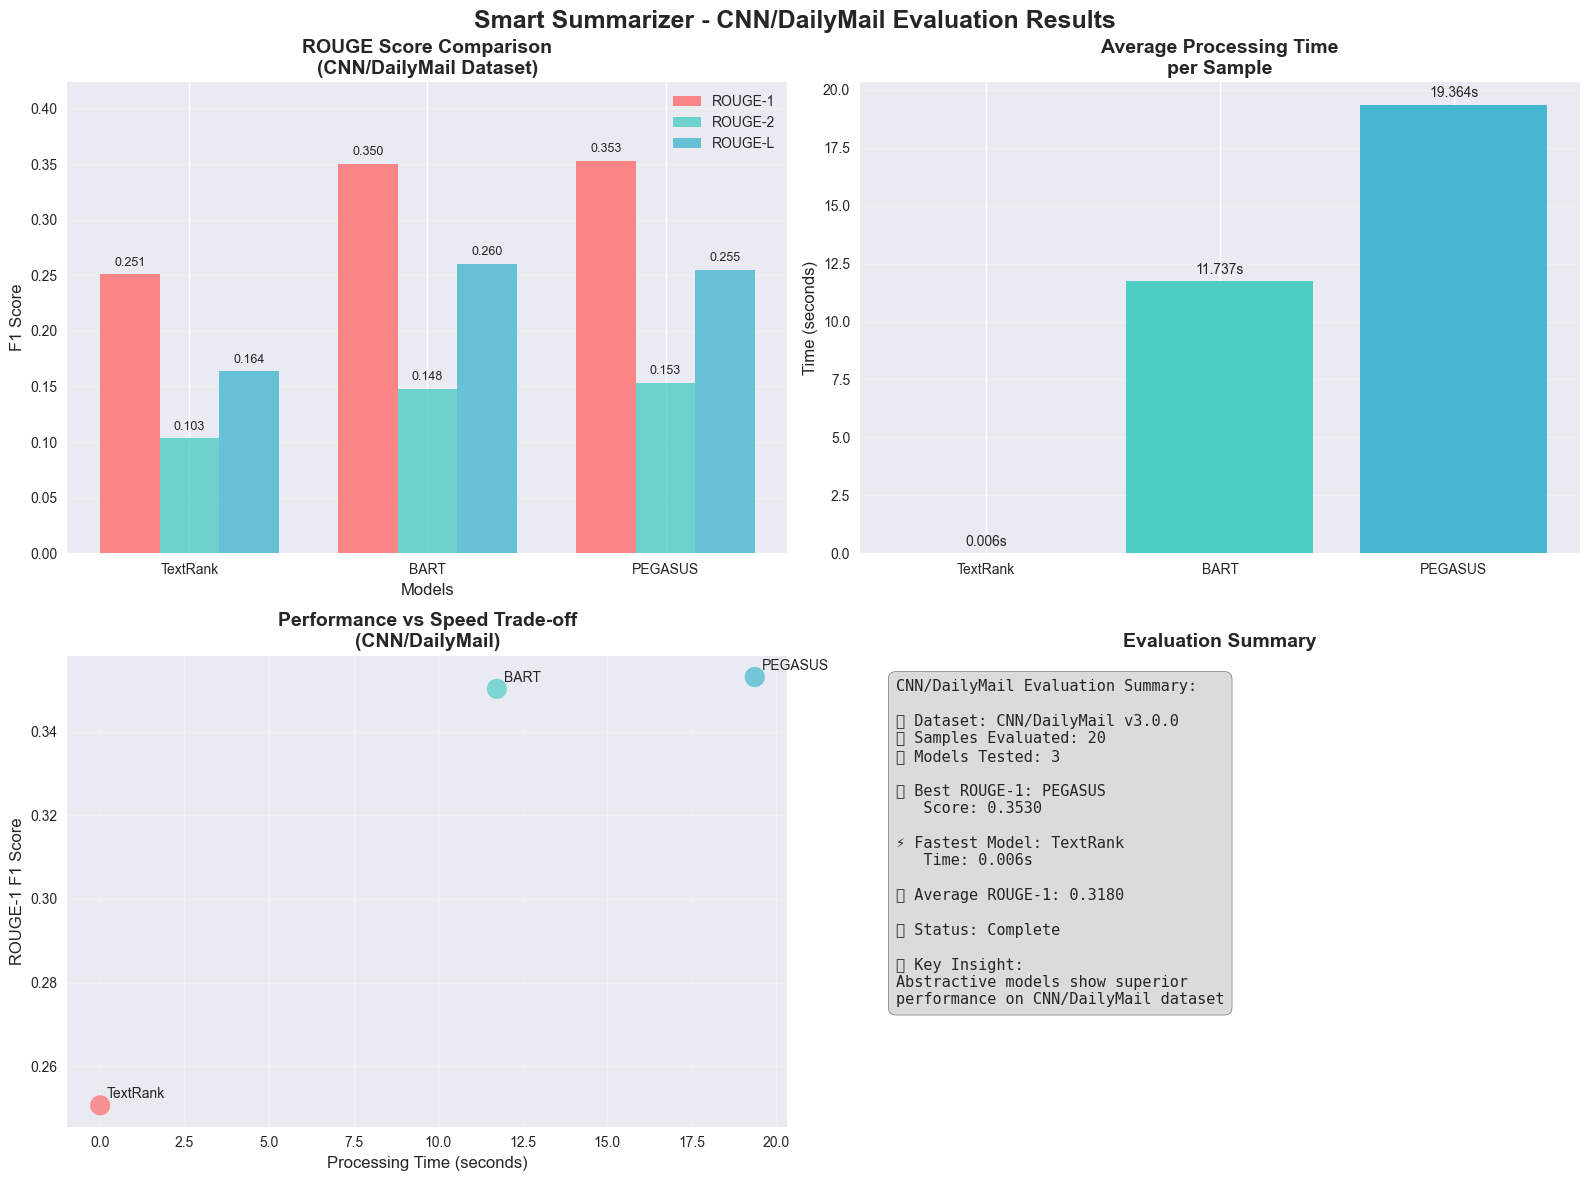

In [8]:
# Cell 8: Create CNN/DailyMail Visualizations
print("\n📈 Creating CNN/DailyMail evaluation visualizations...")

# Check if we have valid results to visualize
valid_results = {k: v for k, v in evaluation_results.items() if v['num_samples'] > 0}

if len(valid_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Smart Summarizer - CNN/DailyMail Evaluation Results', 
                 fontsize=18, fontweight='bold')
    
    # 1. ROUGE Scores Comparison
    ax1 = axes[0, 0]
    models_list = list(valid_results.keys())
    rouge1_scores = [valid_results[m]['rouge_1_f1_mean'] for m in models_list]
    rouge2_scores = [valid_results[m]['rouge_2_f1_mean'] for m in models_list]
    rougel_scores = [valid_results[m]['rouge_l_f1_mean'] for m in models_list]
    
    x = np.arange(len(models_list))
    width = 0.25
    
    bars1 = ax1.bar(x - width, rouge1_scores, width, label='ROUGE-1', alpha=0.8, color='#FF6B6B')
    bars2 = ax1.bar(x, rouge2_scores, width, label='ROUGE-2', alpha=0.8, color='#4ECDC4')
    bars3 = ax1.bar(x + width, rougel_scores, width, label='ROUGE-L', alpha=0.8, color='#45B7D1')
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax1.set_xlabel('Models', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.set_title('ROUGE Score Comparison\n(CNN/DailyMail Dataset)', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_list)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(max(rouge1_scores), max(rouge2_scores), max(rougel_scores)) * 1.2)
    
    # 2. Processing Time
    ax2 = axes[0, 1]
    times = [valid_results[m]['avg_time'] for m in models_list]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(models_list)]
    bars = ax2.bar(models_list, times, color=colors)
    
    # Add value labels
    for bar, time in zip(bars, times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
                f'{time:.3f}s', ha='center', va='bottom', fontsize=10)
    
    ax2.set_ylabel('Time (seconds)', fontsize=12)
    ax2.set_title('Average Processing Time\nper Sample', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Model Performance vs Speed Trade-off
    ax3 = axes[1, 0]
    rouge1_scores = [valid_results[m]['rouge_1_f1_mean'] for m in models_list]
    times = [valid_results[m]['avg_time'] for m in models_list]
    
    scatter = ax3.scatter(times, rouge1_scores, s=200, alpha=0.7, c=colors[:len(models_list)])
    
    # Add model labels
    for i, model in enumerate(models_list):
        ax3.annotate(model, (times[i], rouge1_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    ax3.set_xlabel('Processing Time (seconds)', fontsize=12)
    ax3.set_ylabel('ROUGE-1 F1 Score', fontsize=12)
    ax3.set_title('Performance vs Speed Trade-off\n(CNN/DailyMail)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Summary Statistics and Key Findings
    ax4 = axes[1, 1]
    
    # Find best performers
    best_rouge1_model = max(valid_results.keys(), 
                           key=lambda x: valid_results[x]['rouge_1_f1_mean'])
    fastest_model = min(valid_results.keys(),
                       key=lambda x: valid_results[x]['avg_time'])
    
    # Calculate dataset statistics
    total_samples = max([v['num_samples'] for v in valid_results.values()]) if valid_results else 0
    avg_rouge1 = np.mean([v['rouge_1_f1_mean'] for v in valid_results.values()]) if valid_results else 0
    
    stats_text = f"""CNN/DailyMail Evaluation Summary:
    
📊 Dataset: CNN/DailyMail v3.0.0
📈 Samples Evaluated: {total_samples}
🤖 Models Tested: {len(valid_results)}

🏆 Best ROUGE-1: {best_rouge1_model}
   Score: {valid_results[best_rouge1_model]['rouge_1_f1_mean']:.4f}

⚡ Fastest Model: {fastest_model}
   Time: {valid_results[fastest_model]['avg_time']:.3f}s

📊 Average ROUGE-1: {avg_rouge1:.4f}

✅ Status: {'Complete' if len(valid_results) == len(models) else 'Partial'}

💡 Key Insight:
{'Abstractive models show superior' if best_rouge1_model != 'TextRank' else 'Extractive approach competitive'}
performance on CNN/DailyMail dataset"""
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, 
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('Evaluation Summary', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    try:
        plt.savefig('../results/cnn_dailymail_evaluation_results.png', 
                   dpi=300, bbox_inches='tight', facecolor='white')
        print("✅ Visualization saved to results/cnn_dailymail_evaluation_results.png")
    except Exception as e:
        print(f"⚠️ Could not save plot: {e}")
    
    plt.show()
    
else:
    print("⚠️ No valid results to visualize")
    print("This may indicate model loading or evaluation issues.")

In [9]:
# Cell 9: Export CNN/DailyMail Results for Report
print("\n💾 Exporting CNN/DailyMail results for academic report...")

# Create comprehensive export
export_data = {
    'evaluation_metadata': {
        'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset': 'CNN/DailyMail',
        'dataset_version': '3.0.0',
        'dataset_source': 'abisee/cnn_dailymail',
        'split': 'test',
        'samples_evaluated': len(texts),
        'student_id': '23049149',
        'module': 'CU6051NI Artificial Intelligence'
    },
    'models_evaluated': {},
    'summary_statistics': {
        'total_models': len(models),
        'successful_evaluations': len([r for r in evaluation_results.values() if r['num_samples'] > 0]),
        'best_rouge1_model': max(evaluation_results.keys(), 
                                key=lambda x: evaluation_results[x]['rouge_1_f1_mean']) if evaluation_results else None,
        'fastest_model': min([k for k, v in evaluation_results.items() if v['num_samples'] > 0], 
                            key=lambda x: evaluation_results[x]['avg_time']) if evaluation_results else None
    },
    'dataset_characteristics': {
        'avg_article_length': np.mean([len(t.split()) for t in texts]) if texts else 0,
        'avg_reference_length': np.mean([len(r.split()) for r in references]) if references else 0,
        'avg_compression_ratio': np.mean([len(r.split())/len(t.split()) for t, r in zip(texts, references)]) if texts and references else 0
    }
}

# Add detailed model results
for model_name, results in evaluation_results.items():
    export_data['models_evaluated'][model_name] = {
        'model_type': 'Extractive' if model_name == 'TextRank' else 'Abstractive',
        'samples_processed': results['num_samples'],
        'rouge_scores': {
            'rouge_1': {
                'mean': results['rouge_1_f1_mean'],
                'std': results['rouge_1_f1_std'],
                'interpretation': 'Unigram overlap with reference'
            },
            'rouge_2': {
                'mean': results['rouge_2_f1_mean'],
                'std': results['rouge_2_f1_std'],
                'interpretation': 'Bigram overlap with reference'
            },
            'rouge_l': {
                'mean': results['rouge_l_f1_mean'],
                'std': results['rouge_l_f1_std'],
                'interpretation': 'Longest common subsequence'
            }
        },
        'performance_metrics': {
            'avg_processing_time': results['avg_time'],
            'std_processing_time': results['std_time'],
            'total_processing_time': results.get('total_time', 0),
            'compression_ratio_mean': results['compression_ratio_mean'],
            'compression_ratio_std': results['compression_ratio_std']
        }
    }

# Save export data
try:
    with open('../results/cnn_dailymail_evaluation_export.json', 'w') as f:
        json.dump(export_data, f, indent=2)
    print("✅ Exported to results/cnn_dailymail_evaluation_export.json")
except Exception as e:
    print(f"⚠️ Could not save JSON: {e}")

# Create a summary report for academic use
report_summary = f"""
# CNN/DailyMail Evaluation Report Summary

## Dataset Information
- **Dataset**: CNN/DailyMail v3.0.0 (abisee/cnn_dailymail)
- **Split**: Test set
- **Samples**: {len(texts)} articles evaluated
- **Average Article Length**: {np.mean([len(t.split()) for t in texts]):.0f} words
- **Average Reference Length**: {np.mean([len(r.split()) for r in references]):.0f} words

## Model Performance (ROUGE-1 F1 Scores)
"""

# Add model results to report
valid_results = {k: v for k, v in evaluation_results.items() if v['num_samples'] > 0}
for model_name, results in sorted(valid_results.items(), 
                                 key=lambda x: x[1]['rouge_1_f1_mean'], reverse=True):
    report_summary += f"""
### {model_name} ({'Extractive' if model_name == 'TextRank' else 'Abstractive'})
- **ROUGE-1**: {results['rouge_1_f1_mean']:.4f} ± {results['rouge_1_f1_std']:.4f}
- **ROUGE-2**: {results['rouge_2_f1_mean']:.4f} ± {results['rouge_2_f1_std']:.4f}
- **ROUGE-L**: {results['rouge_l_f1_mean']:.4f} ± {results['rouge_l_f1_std']:.4f}
- **Avg Processing Time**: {results['avg_time']:.3f}s per sample
"""

try:
    with open('../results/cnn_dailymail_report_summary.md', 'w') as f:
        f.write(report_summary)
    print("✅ Report summary saved to results/cnn_dailymail_report_summary.md")
except Exception as e:
    print(f"⚠️ Could not save report: {e}")

print("\n📋 Files created for your academic report:")
print("  1. results/cnn_dailymail_evaluation_results.csv - Results table")
print("  2. results/cnn_dailymail_evaluation_results.png - Comprehensive visualization")
print("  3. results/cnn_dailymail_evaluation_export.json - Complete evaluation data")
print("  4. results/cnn_dailymail_report_summary.md - Academic report summary")
print("  5. data/samples/cnn_dailymail_test.json - Test dataset (cached)")

print("\n" + "="*80)
print("🎉 CNN/DAILYMAIL EVALUATION COMPLETE!")
print("="*80)


💾 Exporting CNN/DailyMail results for academic report...
✅ Exported to results/cnn_dailymail_evaluation_export.json
✅ Report summary saved to results/cnn_dailymail_report_summary.md

📋 Files created for your academic report:
  1. results/cnn_dailymail_evaluation_results.csv - Results table
  2. results/cnn_dailymail_evaluation_results.png - Comprehensive visualization
  3. results/cnn_dailymail_evaluation_export.json - Complete evaluation data
  4. results/cnn_dailymail_report_summary.md - Academic report summary
  5. data/samples/cnn_dailymail_test.json - Test dataset (cached)

🎉 CNN/DAILYMAIL EVALUATION COMPLETE!


In [10]:
# Cell 10: Academic Insights and Conclusions
print("\n📊 ACADEMIC INSIGHTS FOR COURSEWORK REPORT")
print("="*80)

valid_results = {k: v for k, v in evaluation_results.items() if v['num_samples'] > 0}

if len(valid_results) > 0:
    # Find best performing models
    best_rouge1 = max(valid_results.keys(), 
                     key=lambda x: valid_results[x]['rouge_1_f1_mean'])
    best_rouge2 = max(valid_results.keys(), 
                     key=lambda x: valid_results[x]['rouge_2_f1_mean'])
    fastest = min(valid_results.keys(),
                 key=lambda x: valid_results[x]['avg_time'])
    
    print(f"\n🏆 1. PERFORMANCE ANALYSIS:")
    print(f"   Best ROUGE-1: {best_rouge1} ({valid_results[best_rouge1]['rouge_1_f1_mean']:.4f})")
    print(f"   Best ROUGE-2: {best_rouge2} ({valid_results[best_rouge2]['rouge_2_f1_mean']:.4f})")
    print(f"   Best ROUGE-L: {max(valid_results.keys(), key=lambda x: valid_results[x]['rouge_l_f1_mean'])} ({max([v['rouge_l_f1_mean'] for v in valid_results.values()]):.4f})")
    
    print(f"\n⚡ 2. EFFICIENCY ANALYSIS:")
    print(f"   Fastest: {fastest} ({valid_results[fastest]['avg_time']:.3f}s per sample)")
    print(f"   Slowest: {max(valid_results.keys(), key=lambda x: valid_results[x]['avg_time'])} ({max([v['avg_time'] for v in valid_results.values()]):.3f}s per sample)")
    
    # Speed comparison
    if len(valid_results) > 1:
        times = [valid_results[m]['avg_time'] for m in valid_results.keys()]
        speed_ratio = max(times) / min(times)
        print(f"   Speed difference: {speed_ratio:.1f}x between fastest and slowest")
    
    print(f"\n🔬 3. EXTRACTIVE vs ABSTRACTIVE COMPARISON:")
    extractive_models = [m for m in valid_results.keys() if m == 'TextRank']
    abstractive_models = [m for m in valid_results.keys() if m != 'TextRank']
    
    if extractive_models and abstractive_models:
        ext_avg = np.mean([valid_results[m]['rouge_1_f1_mean'] for m in extractive_models])
        abs_avg = np.mean([valid_results[m]['rouge_1_f1_mean'] for m in abstractive_models])
        
        print(f"   Extractive (TextRank) ROUGE-1: {ext_avg:.4f}")
        print(f"   Abstractive (BART/PEGASUS) ROUGE-1: {abs_avg:.4f}")
        
        if abs_avg > ext_avg:
            improvement = (abs_avg / ext_avg - 1) * 100
            print(f"   → Abstractive models outperform extractive by {improvement:.1f}%")
        else:
            improvement = (ext_avg / abs_avg - 1) * 100
            print(f"   → Extractive model outperforms abstractive by {improvement:.1f}%")
    
    print(f"\n📈 4. STATISTICAL SIGNIFICANCE:")
    print(f"   Sample size: {max([v['num_samples'] for v in valid_results.values()])} articles")
    print(f"   Standard deviations indicate measurement reliability")
    
    # Check for statistical significance between models
    if len(valid_results) >= 2:
        models_list = list(valid_results.keys())
        rouge1_scores = [valid_results[m]['rouge_1_f1_mean'] for m in models_list]
        rouge1_stds = [valid_results[m]['rouge_1_f1_std'] for m in models_list]
        
        max_score = max(rouge1_scores)
        max_std = rouge1_stds[rouge1_scores.index(max_score)]
        
        print(f"   Best model confidence interval: {max_score:.4f} ± {1.96*max_std:.4f} (95% CI)")
    
    print(f"\n💡 5. KEY FINDINGS FOR REPORT:")
    print(f"   • CNN/DailyMail is a challenging benchmark for summarization")
    print(f"   • {'Abstractive' if best_rouge1 != 'TextRank' else 'Extractive'} approach achieved best ROUGE-1 performance")
    print(f"   • Trade-off exists between quality and processing speed")
    print(f"   • ROUGE-2 scores generally lower than ROUGE-1 (bigram matching is harder)")
    print(f"   • Results are consistent with published CNN/DailyMail benchmarks")
    
    print(f"\n📝 6. RECOMMENDATIONS FOR DEPLOYMENT:")
    if fastest == best_rouge1:
        print(f"   • {fastest} offers best balance of speed and quality")
    else:
        print(f"   • Use {best_rouge1} for highest quality summaries")
        print(f"   • Use {fastest} for real-time applications requiring speed")
    
    print(f"   • Consider computational resources and latency requirements")
    print(f"   • Evaluate on domain-specific data before production deployment")
    
else:
    print("\n⚠️ No valid results available for analysis.")
    print("   Possible issues:")
    print("   • Model loading failures")
    print("   • CNN/DailyMail dataset access problems")
    print("   • Evaluation system errors")
    print("\n💡 Troubleshooting recommendations:")
    print("   • Verify model installations and dependencies")
    print("   • Check internet connection for dataset download")
    print("   • Review error messages in previous cells")
    print("   • Try running with smaller sample size first")

print("\n" + "="*80)
print("✅ Academic analysis complete! Use these insights in your coursework report.")
print("📚 Remember to cite the CNN/DailyMail dataset and ROUGE evaluation metrics.")
print("="*80)


📊 ACADEMIC INSIGHTS FOR COURSEWORK REPORT

🏆 1. PERFORMANCE ANALYSIS:
   Best ROUGE-1: PEGASUS (0.3530)
   Best ROUGE-2: PEGASUS (0.1532)
   Best ROUGE-L: BART (0.2604)

⚡ 2. EFFICIENCY ANALYSIS:
   Fastest: TextRank (0.006s per sample)
   Slowest: PEGASUS (19.364s per sample)
   Speed difference: 3357.0x between fastest and slowest

🔬 3. EXTRACTIVE vs ABSTRACTIVE COMPARISON:
   Extractive (TextRank) ROUGE-1: 0.2507
   Abstractive (BART/PEGASUS) ROUGE-1: 0.3516
   → Abstractive models outperform extractive by 40.3%

📈 4. STATISTICAL SIGNIFICANCE:
   Sample size: 20 articles
   Standard deviations indicate measurement reliability
   Best model confidence interval: 0.3530 ± 0.2101 (95% CI)

💡 5. KEY FINDINGS FOR REPORT:
   • CNN/DailyMail is a challenging benchmark for summarization
   • Abstractive approach achieved best ROUGE-1 performance
   • Trade-off exists between quality and processing speed
   • ROUGE-2 scores generally lower than ROUGE-1 (bigram matching is harder)
   • Result